In [ ]:
import torch
import torch.nn as nn  # Pytorch Neural Network
import torch.optim as optim  # Optimization
import torchvision  #For datasets and transforms
import torchvision.transforms as transforms  #for data preprocessing
import torchvision.models as models  # Import pretrained models from torchvision
import timm  #For Vision Transformer models
from torch.cuda.amp import autocast, GradScaler  # Import mixed precision training tools
import matplotlib.pyplot as plt  #Import matplotlib for plotting
import numpy as np  #numerical operations
import pickle #for saving model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU
print(f"Using device: {device}")

Using device: cuda


In [ ]:
#################################################################################
# Data transformation pipeline with augmentations and normalization
# This section deals with a series of image transformation operations that will be applied on the CIFAR-100 dataset
#################################################################################

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop image to 32x32
    transforms.RandomHorizontalFlip(),  #flip image horizontally
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),  # CIFAR normalize numbers
])

#################################################################################
# Dataset Loading & Splitting
# This section is where I download and load the CIFAR-100 dataset using torchvision to preprocess the data
# I split the training dataset into a training subset containing 45,000 images and a validation subset containing 5,000 images to evaluate the model. The test dataset is separate
#################################################################################

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)  # Load CIFAR-100 training set
valset = torch.utils.data.Subset(trainset, range(45000, 50000))  # Create validation subset
trainset = torch.utils.data.Subset(trainset, range(45000))  # Create training subset
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)  # Load CIFAR-100 test set

#################################################################################
#Data Loaders
# trainloader to shuffle training data in batches of 64
# valloader to load validation data in batches to evaluate model performance
# testloader to load test data in batches for assessment
#################################################################################
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)  # Create training data loader
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)  # Create validation data loader
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)  # Create test data loader

100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


In [ ]:
def random_mask_patches(patches, mask_ratio):
    """
    Randomly masking patches from input tensor

    Parameters:
     -patches (Tensor): A tensor of shape (B, N, D) where B is the batch size, N is number of patches, and D is embedding dimension
     -mask_ratio: what percentage of the patches to mask out

    Returns:
    -visible (tensor): returns the visible patches,
    -mask (tensor): binary mask indicating which patches were masked out

    """
    B, N, D = patches.shape  # Get batch size, patches, and embedding dimension
    num_masked = int(mask_ratio * N)  # Calculate number of patches to mask
    mask = torch.ones(B, N, device=patches.device)  # Create mask tensor with all 1s on device
    idx = torch.rand(B, N, device=patches.device).argsort(dim=-1)  # Generate random indices for masking
    mask.scatter_(1, idx[:, :num_masked], 0)  # Set masked indices to 0 in mask tensor
    visible = patches[mask.bool()].view(B, -1, D)  # Extract visible patches and reshape
    return visible, mask  # Return visible patches and mask tensor

In [ ]:
def importance_mask_patches(patches, images, mask_ratio, importance_model):
    """
    Masking patches based on importance scores using importance model. The function computes importance score for a patch using
    a pre-trained network. Patches with a lower score have higher chance of getting masked

    Parameters
      -patches (Tensor): A tensor of shape (B, N, D) where B is the batch size, N is number of patches, and D is embedding dimension
      -images (Tensor): Tensor of images that will be used to compute an importance score
      -mask_ratio: what fraction of patches (Example: 30% of patches)
      -importance_model: Model (ResNet18) to compute the feature maps for each patch which will get the importance score

    Returns:
      -visible (tensor): returns the visible patches
      -mask (tensor): binary mask indicating which patches were masked out
    """

    # print("Entered importance_mask_patches function")  # Confirm function entry
    # print(f"Debug: images shape before processing: {images.shape}")  # Debug print before processing
    B, N, D = patches.shape  # Get batch size, patches, and embedding dimension
    num_masked = int(mask_ratio * N)  # Calculate number of patches to mask

    with torch.no_grad():
        # Resize images to 224x224 to match ResNet18 pretrained input
        images_resized = nn.functional.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
        features = importance_model.conv1(images_resized.to(device))  # Start with the first conv layer
        features = importance_model.bn1(features)
        features = importance_model.relu(features)
        features = importance_model.maxpool(features)
        features = importance_model.layer1(features)
        features = importance_model.layer2(features)
        features = importance_model.layer3(features)
        features = importance_model.layer4(features)  # Get features from layer4
        # print(f"Debug: features shape after layer4: {features.shape}")  # Debug print after layer4
        # Ensure features are in [B, C, H, W] format
        if features.dim() != 4:
            raise ValueError(f"Unexpected features shape {features.shape}, expected [B, C, H, W]")

        # Interpolate to match the 8x8 patch grid (assuming original 32x32 input)
        features = nn.functional.interpolate(features, size=(8, 8), mode='bilinear', align_corners=False)
        importance_scores = features.mean(dim=1).view(B, -1)  # Average over channels to get patch scores

    importance_scores = (importance_scores - importance_scores.min(dim=1, keepdim=True)[0])  #Normalize scores: subtract min
    importance_scores = importance_scores / (importance_scores.max(dim=1, keepdim=True)[0] + 1e-6)  # Normalize scores: divide by max
    mask_probs = 1 - importance_scores[:, :N]  #Invert scores to get masking probabilities, trim to N patches
    mask = torch.ones(B, N, device=device)  # Create mask tensor with all 1s
    idx = torch.multinomial(mask_probs, num_masked, replacement=False)  # Sample patches to mask based on probabilities
    mask.scatter_(1, idx, 0)  # Set masked indices to 0 in mask tensor
    visible = patches[mask.bool()].view(B, -1, D)  # Extract visible patches and reshape
    return visible, mask  # Return visible patches and mask tensor

In [ ]:
#################################################################################
# The Baseline ViT class is designed for classification tasks.

# There is an encoder and classification head to output logits over number of classes.
# Essentially, this classifier takes small images and decides the categories in
# which they belong to. The ViT breaks the images into components, understands
# them and then produce a series of numbers called logits which is a score that
# indicates how strongly a network believes that an image fits this category.
#################################################################################

class BaselineViT(nn.Module):
    def __init__(self, num_classes=100):  # Initialize with number of classes
        super().__init__()  #Call parent class constructor
        self.encoder = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=0, img_size=32, patch_size=4) #Create ViT small patch encoder
        self.encoder.patch_embed.proj = nn.Conv2d(3, 384, kernel_size=4, stride=4) #Adjust patch embedding to 4x4
        self.cls_head = nn.Linear(384, num_classes)

    def forward(self, x):
        x = self.encoder(x)  # Pass input through ViT encoder
        return self.cls_head(x)  # Return classification logits

In [ ]:
#################################################################################
# The JointViT Class is designed for both classification and patch reconstruction
# tasks.
#################################################################################
class JointViT(nn.Module):
    def __init__(self, num_classes=100, mask_ratio=0.75, use_importance=False, device=None):
        """
        Initializing the JointViT model

        Parameters:
          -num_classes: how many classes for classification tasks, set to 100
          -mask_ratio: ratio of image patches to mask for reconstruction
          -use_importance: using either random or importance masking
          -device: use GPU

        Create encoder from a small patch ViT library, configured for 32x32 images.
        The patch embedding layer is adjusted to a convolutional layer to divide the image
        The Classification head outputs the class logits

        Create a decoder composed of 3 layers:
          1. linear layer to reduce encoder's embedding size
          2. transformer decoder for patch reconstruction
          3. linear layer to output pixel values for each patch

        The mask token replaces masked patches. It helps the model understand what a missing patch looks like so during
        reconstruction, it can fill in or predict what the original patch might be

        The positional embedding is the label that tells the model where each patch belongs in the image so the model knows
        where it is with respect to the rest of the image

        Then, load a ResNet18 model which is pretrained to understand visual patterns to assess which patches are more significant

        """
        super().__init__()
        self.mask_ratio = mask_ratio  # Set mask ratio attribute
        self.use_importance = use_importance  # Set importance masking flag
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Device = GPU
        self.encoder = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=0, img_size=32, patch_size=4).to(self.device)  # Create ViT-S encoder
        self.encoder.patch_embed.proj = nn.Conv2d(3, 384, kernel_size=4, stride=4).to(self.device)  # Adjust patch embedding to 4x4
        self.cls_head = nn.Linear(384, num_classes).to(self.device)  # Define classification head
        self.decoder = nn.Sequential(  # Define decoder as sequential layers
            nn.Linear(384, 256).to(self.device),  # Linear layer to reduce embedding size
            nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=256, nhead=8).to(self.device), num_layers=2),  # Transformer decoder with 2 layers
            nn.Linear(256, 48).to(self.device)  # Linear layer to output patch pixels (4x4x3)
        ).to(self.device)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, 384).to(self.device))  # Define learnable mask token
        self.pos_embed = nn.Parameter(torch.zeros(1, 65, 384).to(self.device))  # Define positional embeddings for 64 patches + cls token
        self.importance_model = models.resnet18(pretrained=True).to(self.device)  # Load pretrained ResNet18 for importance scores

    def forward(self, x, return_recon=True):
        """
        Parameters:
          -x (Tensor) takes images of shape (B, # of channels (3 in this case), image size)
          -return_recon: determines if we output classification logits and patch reconstruction or just classification logits

        Return
          -classification logits: a score that indicates how strongly a network believes that an image fits this category
          -recon: reconstructed image patches
          -mask: binary mask indicating which patches were masked out

        First, clone the input because it needs to be reconstructed later. Then convert the input image to patch embeddings using encoder.
        Expand the class token and add embeddings to the tokens. If return_recon is true, simultaneously reconstruct masked patches and obtain classification logits.
        Otherwise, only obtain classification logits.
        """

        B = x.shape[0]  # Get batch size
        original_x = x.clone().detach()  # Store and detach the original input image to avoid gradient issues
        # print(f"Debug: Entering forward with return_recon={return_recon}, x.shape={x.shape}")  # Debug entry point
        patches = self.encoder.patch_embed(x.to(self.device))  # Convert image to patch embeddings on device
        cls_token = self.encoder.cls_token.expand(B, -1, -1)  # Expand cls token for batch
        x = torch.cat([cls_token, patches], dim=1) + self.pos_embed  # Concatenate cls token and patches and add positional embeddings

        if not return_recon:  # Exit early if no reconstruction is needed
            # print("Debug: Early return for return_recon=False")  # Debug early return
            encoded = self.encoder.blocks(self.encoder.norm_pre(x))  # Pass through transformer layers
            encoded = self.encoder.norm(encoded)  # Apply final normalization
            cls_logits = self.cls_head(encoded[:, 0])  # Get classification logits from cls token
            # print(f"Debug: Returning cls_logits shape (no recon): {cls_logits.shape}")  # Debug print
            return cls_logits  # Return only classification logits as a tensor

        # Proceed with reconstruction
        patches_only = x[:, 1:, :]  # Extract patches (exclude cls token)
        # print(f"Debug: Patches_only shape before masking: {patches_only.shape}")  # Debug print for patches
        if self.use_importance:  # Use importance masking if flag
            # print(f"Debug: Passing original_x to importance_mask_patches: {original_x.shape}")  # Debug before call
            visible, mask = importance_mask_patches(patches_only, original_x, self.mask_ratio, self.importance_model)  # Use original image
            # print(f"Debug: Visible shape after importance masking: {visible.shape}")  # Debug print for visible patches
        else:  # Else use random masking
            visible, mask = random_mask_patches(patches_only, self.mask_ratio)  # Mask randomly
            # print(f"Debug: Visible shape after random masking: {visible.shape}")  # Debug print for visible patches
        x = torch.cat([x[:, :1, :], visible], dim=1)  # Re-add cls token to visible patches

        encoded = self.encoder.blocks(self.encoder.norm_pre(x))  # Pass through transformer layers
        encoded = self.encoder.norm(encoded)  # Apply final normalization
        cls_logits = self.cls_head(encoded[:, 0])  # Get classification logits from cls token

        visible_patches = encoded[:, 1:, :]  # Extract encoded visible patches
        masked_tokens = self.mask_token.expand(B, 64 - visible_patches.shape[1], -1)  # Create mask tokens for masked patches
        decoder_input = torch.zeros(B, 64, 384, device=self.device)  # Initialize decoder input tensor on device
        decoder_input[mask.bool()] = visible_patches.flatten(0, 1)  # Fill visible patch positions
        decoder_input[~mask.bool()] = masked_tokens.flatten(0, 1)  # Fill masked patch positions with mask tokens
        recon = decoder_input  # Set initial reconstruction input
        for layer in self.decoder:  # Iterate through decoder layers
            recon = layer(recon) if 'Transformer' not in str(layer) else layer(recon, recon)
        recon = recon.view(B, 64, 4, 4, 3)  # Reshape reconstruction to patch format
        # print(f"Debug: Returning cls_logits, recon, mask shapes: {cls_logits.shape}, {recon.shape}, {mask.shape}")  # Debug print
        return cls_logits, recon, mask

In [ ]:
def train_model(model, trainloader, valloader, epochs=50, alpha=None, device=None):
  """
  Parameters:
    -model: The neural network that's being trained. BaselineViT or JointViT
    -trainloader: dataloader for training dataset
    -valloader: dataloader for validation dataset
    -epochs: training loops set to 50
    -alpha: how much reconstructional loss. If none, only do classification loss but otherwise, classification + (loss x alpha)
    -device: use GPU

  Returns:
    -cls_losses: classification losses for each epoch
    -recon_losses: reconstruction losses for each epoch
    -val_accs: validation accuracies for each epoch

  This function trains the model using both classification and reconstruction loss, where model is trained on trainloader and
  evaluated on validation loader at the end of each epoch. 2 modes supported

  1. Classification: Model outputs classification logits, loss calculated using CrossEntropyLoss
  2. Joint Training: Model outputs classification logits and reconstruction of patches. Total loss
  is calculated using the sum of the classification loss and the reconstruction loss.
  """


    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if hasattr(model, 'device'):
        device = model.device
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)  # Initialize AdamW optimizer
    cls_criterion = nn.CrossEntropyLoss()  # Define cross-entropy loss for classification
    recon_criterion = nn.MSELoss() if alpha is not None else None  # Define MSE loss for reconstruction if needed
    scaler = GradScaler()  # Initialize gradient scaler for mixed precision

    cls_losses, recon_losses, val_accs = [], [], []  # Initialize lists to store metrics
    for epoch in range(epochs):  # Loop over epochs
        model.train()  # Model is training
        cls_loss_epoch, recon_loss_epoch = 0, 0
        for images, labels in trainloader:  # Loop over trainloader
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # No gradients
            with autocast():  # Enable mixed precision
                if alpha is None:  # Check if baseline model (no reconstruction)
                    if isinstance(model, JointViT):  # Check if model is JointViT
                        cls_logits = model(images, return_recon=False)  # Get cls_logits (tensor) for JointViT
                    else:  # For BaselineViT
                        cls_logits = model(images)  # Get classification logits (tensor) directly
                    loss = cls_criterion(cls_logits, labels)  # Compute classification loss
                else:  # for Joint model with reconstruction
                    cls_logits, recon, mask = model(images, return_recon=True)  # Get full output for reconstruction
                    cls_loss = cls_criterion(cls_logits, labels)  # Compute classification loss
                    recon_target = images.view(-1, 64, 4, 4, 3)  # Reshape target image to patches
                    recon_loss = recon_criterion(recon[~mask.bool()], recon_target[~mask.bool()])  # Compute reconstruction loss
                    loss = cls_loss + alpha * recon_loss  # Combine losses with weighting
                    cls_loss_epoch += cls_loss.item()  # Accumulate classification loss
                    recon_loss_epoch += recon_loss.item()  # Accumulate reconstruction loss
            scaler.scale(loss).backward()  # Scale loss and compute gradients
            scaler.step(optimizer)  # Update weights
            scaler.update()  # Update scaler for next iteration
            cls_loss_epoch += loss.item() if alpha is None else 0  # Accumulate total loss for baseline

        model.eval()  # Model in evaluation mode
        correct, total = 0, 0  # Initialize accuracy counters
        with torch.no_grad():
            for images, labels in valloader:  # Loop over validation batches
                images, labels = images.to(device), labels.to(device)
                if isinstance(model, JointViT):  # Check if model is JointViT
                    cls_logits = model(images, return_recon=False)  # Get only cls_logits for JointViT
                else:  # For BaselineViT or other models
                    cls_logits = model(images)  # Get classification logits (tensor) directly
                _, predicted = cls_logits.max(1)  # Get predicted class indices
                total += labels.size(0)  # Update total count
                correct += predicted.eq(labels).sum().item() # Update correct count
        val_acc = 100. * correct / total  # Compute validation accuracy

        # Calculate average losses for the epoch
        avg_cls_loss = cls_loss_epoch / len(trainloader)
        avg_recon_loss = recon_loss_epoch / len(trainloader) if alpha is not None else 0

        # Store metrics
        cls_losses.append(avg_cls_loss)  # Store average cls loss
        recon_losses.append(avg_recon_loss)  # Store average recon loss
        val_accs.append(val_acc)  # Store validation accuracy

        # Print epoch metrics
        if alpha is None:
            print(f"Epoch {epoch + 1}/{epochs}: "
                  f"Cls Loss: {avg_cls_loss:.4f}, "
                  f"Val Accuracy: {val_acc:.2f}%")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: "
                  f"Cls Loss: {avg_cls_loss:.4f}, "
                  f"Recon Loss: {avg_recon_loss:.4f}, "
                  f"Val Accuracy: {val_acc:.2f}%")

        # Save values after each epoch
        with open(f'training_metrics_epoch_{epoch}_{model.__class__.__name__}.pkl', 'wb') as f:
            pickle.dump({'cls_losses': cls_losses, 'recon_losses': recon_losses, 'val_accs': val_accs}, f)

    # Save metrics after training completes
    with open(f'training_metrics_final_{model.__class__.__name__}.pkl', 'wb') as f:
        pickle.dump({'cls_losses': cls_losses, 'recon_losses': recon_losses, 'val_accs': val_accs}, f)
    return cls_losses, recon_losses, val_accs  # Return metric lists

In [ ]:
def evaluate(model, testloader, device=None):
    """
    Parameters:
      -model: trained model to evaluate
      -testloader: Dataloader providing test dataset
      -device: set device to GPU to run evaluation

      Returns:
      -accuracy: percentage of correctly classified images

      This function evaluates the model on the test dataset and returns the accuracy. For each test batch, it
      obtains predictions and compares prediction vs the true data

    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available()else "cpu")
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0  # accuracy counters
    with torch.no_grad():
        for images, labels in testloader:  # Loop over test batches
            images, labels = images.to(device), labels.to(device)  # Move data to device
            logits = model(images, return_recon=False) if isinstance(model, JointViT) else model(images)  # Get logits
            _, predicted = logits.max(1)  # Get predicted class indices
            total += labels.size(0)  # Update total count
            correct += predicted.eq(labels).sum().item()  # Update correct count
    return 100. * correct / total  # Return test accuracy

def pretrain_mae(model, trainloader, epochs=25, device=None):
    """
    Parameters:
      -model: the model to pretrain
      -trainloader: Dataloader providing training dataset
      -epochs: training iterations
      -device: set device to GPU to run evaluation


      This function trains the model using an MSE loss computed between reconstructed patches and
      the original image patches. During each epoch, model outputs reconstruction and mask and
      the reconstruction loss is also computed. The optimizer then updates these models

    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available()else "cpu")
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # Initialize optimizer
    criterion = nn.MSELoss()  # Define MSE loss
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        for images, _ in trainloader:  # Loop over training batches
            images = images.to(device)
            _, recon, mask = model(images)  # Get reconstruction and mask
            loss = criterion(recon[~mask.bool()], images.view(-1, 64, 4, 4, 3)[~mask.bool()])  # Compute reconstruction loss
            optimizer.zero_grad()
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
        print(f"MAE Pretrain Epoch {epoch}: Loss {loss.item():.4f}")  # Print epoch loss

In [ ]:
# Initialize models
baseline_model = BaselineViT().cuda()  # Create Baseline ViT
joint_random_model = JointViT(use_importance=False).cuda()  # Create JointViT with random masking
joint_importance_model = JointViT(use_importance=True).cuda()  # Create JointViT with importance masking

In [ ]:
print("Training Baseline ViT...")  # Print training start message
baseline_cls_losses, _, baseline_accs = train_model(baseline_model, trainloader, valloader, epochs=50, alpha=None)  # Train BaselineViT



Training Baseline ViT...


<ipython-input-12-a5e9b189cbca>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize gradient scaler for mixed precision
<ipython-input-12-a5e9b189cbca>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision


Epoch 1/50: Cls Loss: 4.0508, Val Accuracy: 10.40%
Epoch 2/50: Cls Loss: 3.6558, Val Accuracy: 14.68%
Epoch 3/50: Cls Loss: 3.4224, Val Accuracy: 18.42%
Epoch 4/50: Cls Loss: 3.2678, Val Accuracy: 19.80%
Epoch 5/50: Cls Loss: 3.1707, Val Accuracy: 20.84%
Epoch 6/50: Cls Loss: 3.0634, Val Accuracy: 23.20%
Epoch 7/50: Cls Loss: 2.9872, Val Accuracy: 24.36%
Epoch 8/50: Cls Loss: 2.8906, Val Accuracy: 25.82%
Epoch 9/50: Cls Loss: 2.7978, Val Accuracy: 28.16%
Epoch 10/50: Cls Loss: 2.7217, Val Accuracy: 26.50%
Epoch 11/50: Cls Loss: 2.6367, Val Accuracy: 29.24%
Epoch 12/50: Cls Loss: 2.5575, Val Accuracy: 30.64%
Epoch 13/50: Cls Loss: 2.4871, Val Accuracy: 31.50%
Epoch 14/50: Cls Loss: 2.4111, Val Accuracy: 33.62%
Epoch 15/50: Cls Loss: 2.3246, Val Accuracy: 34.66%
Epoch 16/50: Cls Loss: 2.2365, Val Accuracy: 34.94%
Epoch 17/50: Cls Loss: 2.1502, Val Accuracy: 35.30%
Epoch 18/50: Cls Loss: 2.0704, Val Accuracy: 36.24%
Epoch 19/50: Cls Loss: 1.9689, Val Accuracy: 37.90%
Epoch 20/50: Cls Loss

In [ ]:
print("Pretraining MAE...")  # Print pretraining start message
pretrain_mae(joint_random_model, trainloader, epochs=20)  # Pretrain JointViT with MAE

Pretraining MAE...
MAE Pretrain Epoch 0: Loss 1.1190
MAE Pretrain Epoch 1: Loss 1.0140
MAE Pretrain Epoch 2: Loss 1.3950
MAE Pretrain Epoch 3: Loss 0.7461
MAE Pretrain Epoch 4: Loss 0.9248
MAE Pretrain Epoch 5: Loss 1.5068
MAE Pretrain Epoch 6: Loss 1.4885
MAE Pretrain Epoch 7: Loss 1.6067
MAE Pretrain Epoch 8: Loss 1.0022
MAE Pretrain Epoch 9: Loss 1.0824
MAE Pretrain Epoch 10: Loss 0.9527
MAE Pretrain Epoch 11: Loss 0.9099
MAE Pretrain Epoch 12: Loss 0.9652
MAE Pretrain Epoch 13: Loss 1.1105
MAE Pretrain Epoch 14: Loss 1.8172
MAE Pretrain Epoch 15: Loss 1.2554
MAE Pretrain Epoch 16: Loss 0.9190
MAE Pretrain Epoch 17: Loss 0.9899
MAE Pretrain Epoch 18: Loss 0.8556
MAE Pretrain Epoch 19: Loss 1.3713


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, else CPU
print(f"Using device: {device}")  # Print the device being used

print("Fine-tuning MAE...")  # Print fine-tuning start message
mae_cls_losses, _, mae_accs = train_model(joint_random_model, trainloader, valloader, epochs=50, alpha=None, device = device)  # Fine-tune MAE model

Using device: cuda
Fine-tuning MAE...


<ipython-input-12-a5e9b189cbca>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize gradient scaler for mixed precision
<ipython-input-12-a5e9b189cbca>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision


Epoch 1/20: Cls Loss: 3.9683, Val Accuracy: 10.22%
Epoch 2/20: Cls Loss: 3.5981, Val Accuracy: 13.62%
Epoch 3/20: Cls Loss: 3.4040, Val Accuracy: 17.18%
Epoch 4/20: Cls Loss: 3.2571, Val Accuracy: 18.86%
Epoch 5/20: Cls Loss: 3.1499, Val Accuracy: 21.96%
Epoch 6/20: Cls Loss: 3.0283, Val Accuracy: 22.14%
Epoch 7/20: Cls Loss: 2.9339, Val Accuracy: 25.76%
Epoch 8/20: Cls Loss: 2.8382, Val Accuracy: 26.92%
Epoch 9/20: Cls Loss: 2.7576, Val Accuracy: 29.02%
Epoch 10/20: Cls Loss: 2.6673, Val Accuracy: 29.42%
Epoch 11/20: Cls Loss: 2.5903, Val Accuracy: 31.64%
Epoch 12/20: Cls Loss: 2.5068, Val Accuracy: 32.64%
Epoch 13/20: Cls Loss: 2.4303, Val Accuracy: 33.62%
Epoch 14/20: Cls Loss: 2.3510, Val Accuracy: 34.86%
Epoch 15/20: Cls Loss: 2.2690, Val Accuracy: 35.44%
Epoch 16/20: Cls Loss: 2.1700, Val Accuracy: 36.36%
Epoch 17/20: Cls Loss: 2.0800, Val Accuracy: 38.16%
Epoch 18/20: Cls Loss: 1.9805, Val Accuracy: 37.94%
Epoch 19/20: Cls Loss: 1.8764, Val Accuracy: 37.68%
Epoch 20/20: Cls Loss

In [ ]:
print("Training Joint ViT (Random Masking)...")  # Print joint random training start message
joint_rand_cls_losses, joint_rand_recon_losses, joint_rand_accs = train_model(joint_random_model, trainloader, valloader, epochs=50, alpha=1.0)  # Train JointViT with random masking



Training Joint ViT (Random Masking)...


<ipython-input-12-a5e9b189cbca>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize gradient scaler for mixed precision
<ipython-input-12-a5e9b189cbca>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision


Epoch 1/50: Cls Loss: 2.6131, Recon Loss: 1.1808, Val Accuracy: 35.92%
Epoch 2/50: Cls Loss: 2.5280, Recon Loss: 1.1508, Val Accuracy: 34.66%
Epoch 3/50: Cls Loss: 2.4781, Recon Loss: 1.1367, Val Accuracy: 36.46%
Epoch 4/50: Cls Loss: 2.4257, Recon Loss: 1.1319, Val Accuracy: 36.44%
Epoch 5/50: Cls Loss: 2.3763, Recon Loss: 1.1285, Val Accuracy: 38.08%
Epoch 6/50: Cls Loss: 2.3298, Recon Loss: 1.1282, Val Accuracy: 38.20%
Epoch 7/50: Cls Loss: 2.2817, Recon Loss: 1.1271, Val Accuracy: 39.50%
Epoch 8/50: Cls Loss: 2.2323, Recon Loss: 1.1257, Val Accuracy: 38.60%
Epoch 9/50: Cls Loss: 2.1790, Recon Loss: 1.1256, Val Accuracy: 39.62%
Epoch 10/50: Cls Loss: 2.1431, Recon Loss: 1.1247, Val Accuracy: 39.80%
Epoch 11/50: Cls Loss: 2.0817, Recon Loss: 1.1257, Val Accuracy: 39.80%
Epoch 12/50: Cls Loss: 2.0355, Recon Loss: 1.1243, Val Accuracy: 38.96%
Epoch 13/50: Cls Loss: 1.9825, Recon Loss: 1.1241, Val Accuracy: 40.58%
Epoch 14/50: Cls Loss: 1.9325, Recon Loss: 1.1245, Val Accuracy: 40.70%
E

In [ ]:
print("Training Joint ViT (Importance Masking)...")  # Print joint importance training start message
joint_imp_cls_losses, joint_imp_recon_losses, joint_imp_accs = train_model(joint_importance_model, trainloader, valloader, epochs=50, alpha=1.0)  # Train JointViT with importance masking

Training Joint ViT (Importance Masking)...


<ipython-input-12-a5e9b189cbca>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize gradient scaler for mixed precision
<ipython-input-12-a5e9b189cbca>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision


Epoch 1/50: Cls Loss: 4.1034, Recon Loss: 1.2058, Val Accuracy: 8.74%
Epoch 2/50: Cls Loss: 3.7950, Recon Loss: 1.1946, Val Accuracy: 10.76%
Epoch 3/50: Cls Loss: 3.6533, Recon Loss: 1.1896, Val Accuracy: 16.00%
Epoch 4/50: Cls Loss: 3.5353, Recon Loss: 1.1829, Val Accuracy: 16.88%
Epoch 5/50: Cls Loss: 3.4428, Recon Loss: 1.1739, Val Accuracy: 18.90%
Epoch 6/50: Cls Loss: 3.3695, Recon Loss: 1.1651, Val Accuracy: 19.12%
Epoch 7/50: Cls Loss: 3.3071, Recon Loss: 1.1550, Val Accuracy: 20.10%
Epoch 8/50: Cls Loss: 3.2511, Recon Loss: 1.1421, Val Accuracy: 21.08%
Epoch 9/50: Cls Loss: 3.1997, Recon Loss: 1.1346, Val Accuracy: 22.12%
Epoch 10/50: Cls Loss: 3.1322, Recon Loss: 1.1309, Val Accuracy: 25.20%
Epoch 11/50: Cls Loss: 3.0915, Recon Loss: 1.1282, Val Accuracy: 23.56%
Epoch 12/50: Cls Loss: 3.0351, Recon Loss: 1.1269, Val Accuracy: 25.28%
Epoch 13/50: Cls Loss: 2.9841, Recon Loss: 1.1254, Val Accuracy: 26.28%
Epoch 14/50: Cls Loss: 2.9309, Recon Loss: 1.1245, Val Accuracy: 27.74%
Ep

In [ ]:
# Evaluate models on test set
baseline_test_acc = evaluate(baseline_model, testloader)  # Compute BaselineViT test accuracy
mae_test_acc = evaluate(joint_random_model, testloader)  # Compute MAE+FT test accuracy
joint_rand_test_acc = evaluate(joint_random_model, testloader)  # Compute Joint Random test accuracy
joint_imp_test_acc = evaluate(joint_importance_model, testloader)  # Compute Joint Importance test accuracy
print(f"Test Accuracies - Baseline: {baseline_test_acc:.2f}%, MAE+FT: {mae_test_acc:.2f}%, "  # Print all test accuracies
      f"Joint Random: {joint_rand_test_acc:.2f}%, Joint Importance: {joint_imp_test_acc:.2f}%")

Test Accuracies - Baseline: 42.44%, MAE+FT: 42.51%, Joint Random: 42.57%, Joint Importance: 42.27%


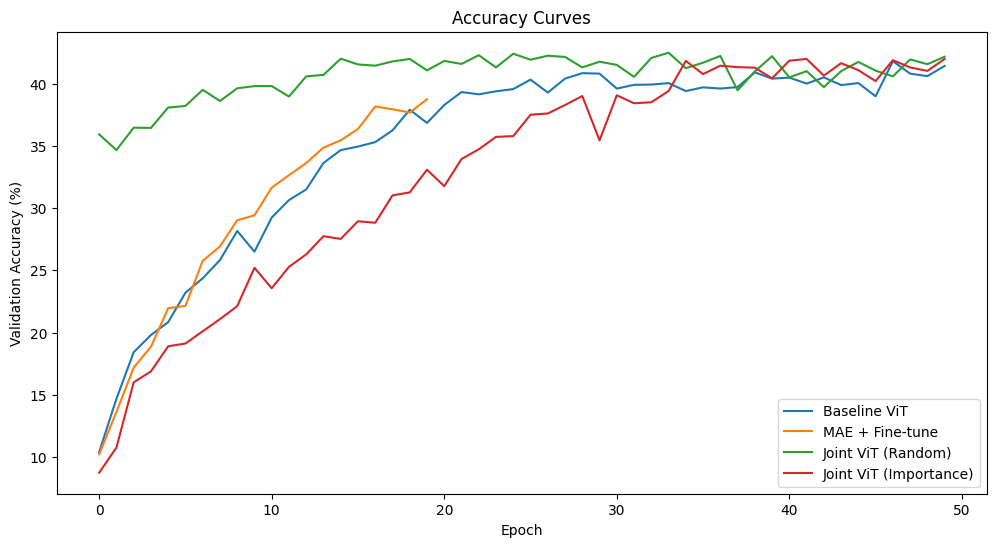

In [ ]:
# Plot accuracy curves
plt.figure(figsize=(12, 6))  # Create figure for accuracy plot
plt.plot(baseline_accs, label='Baseline ViT')  # Plot BaselineViT accuracy curve
plt.plot(mae_accs, label='MAE + Fine-tune')  # Plot MAE+FT accuracy curve
plt.plot(joint_rand_accs, label='Joint ViT (Random)')  # Plot Joint Random accuracy curve
plt.plot(joint_imp_accs, label='Joint ViT (Importance)')  # Plot Joint Importance accuracy curve

# plt.plot(baseline_accs[::10], label='Baseline ViT')
# plt.plot(mae_accs[::10], label='MAE + Fine-tune')
# plt.plot(joint_rand_accs[::10], label='Joint ViT (Random)')
# plt.plot(joint_imp_accs[::10], label='Joint ViT (Importance)')
plt.xlabel('Epoch')  # Set x-axis label
plt.ylabel('Validation Accuracy (%)')  # Set y-axis label
plt.legend()  # Add legend
plt.title('Accuracy Curves')  # Set plot title
plt.savefig('accuracy_curves.png')  # Save accuracy plot

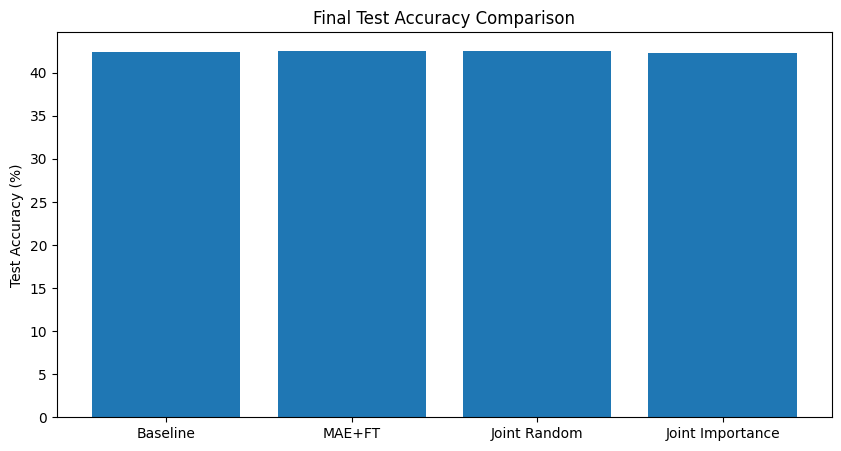

In [ ]:
# Plot final accuracy bar chart
plt.figure(figsize=(10, 5))  # Create figure for bar chart
accuracies = [baseline_test_acc, mae_test_acc, joint_rand_test_acc, joint_imp_test_acc]  # List of test accuracies
labels = ['Baseline', 'MAE+FT', 'Joint Random', 'Joint Importance']  # List of model labels
plt.bar(labels, accuracies)  # Create bar chart
plt.ylabel('Test Accuracy (%)')  # Set y-axis label
plt.title('Final Test Accuracy Comparison')  # Set plot title
plt.savefig('final_accuracy.png')  # Save bar chart



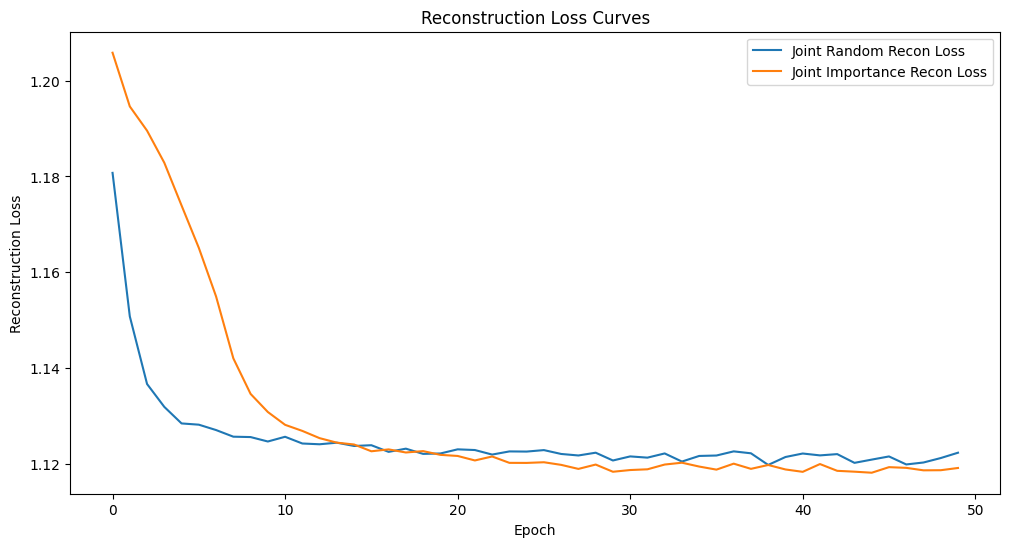

In [ ]:
# Plot reconstruction loss curves
plt.figure(figsize=(12, 6))  # Create figure for loss plot
plt.plot(joint_rand_recon_losses, label='Joint Random Recon Loss')  # Plot Joint Random recon loss curve
plt.plot(joint_imp_recon_losses, label='Joint Importance Recon Loss')  # Plot Joint Importance recon loss curve
plt.xlabel('Epoch')  # Set x-axis label
plt.ylabel('Reconstruction Loss')  # Set y-axis label
plt.legend()  # Add legend
plt.title('Reconstruction Loss Curves')  # Set plot title
plt.savefig('recon_loss_curves.png')  # Save loss plot

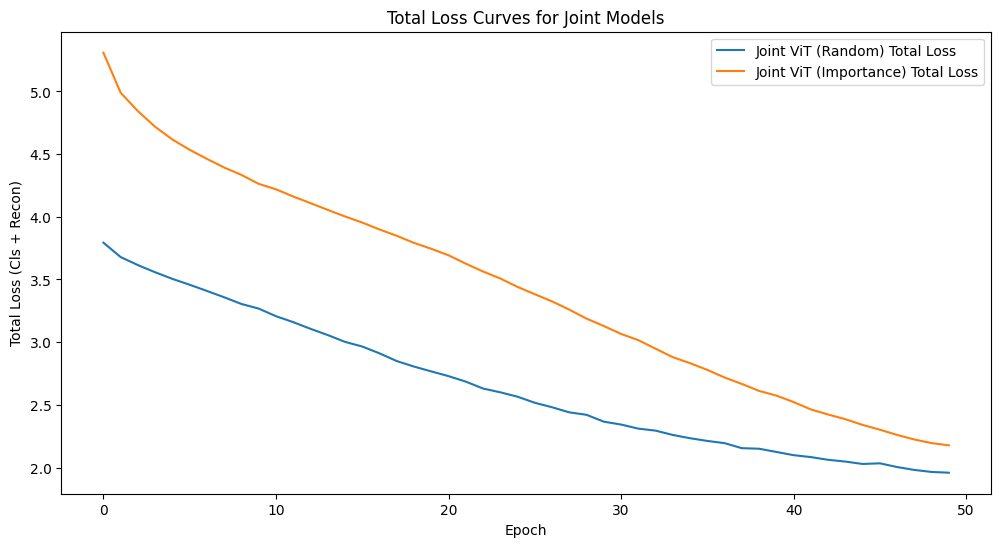

In [ ]:
plt.figure(figsize=(12, 6))
total_rand_loss = [c + r for c, r in zip(joint_rand_cls_losses, joint_rand_recon_losses)]
total_imp_loss = [c + r for c, r in zip(joint_imp_cls_losses, joint_imp_recon_losses)]
plt.plot(total_rand_loss, label='Joint ViT (Random) Total Loss')
plt.plot(total_imp_loss, label='Joint ViT (Importance) Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss (Cls + Recon)')
plt.legend()
plt.title('Total Loss Curves for Joint Models')
plt.savefig('total_loss_curves.png')

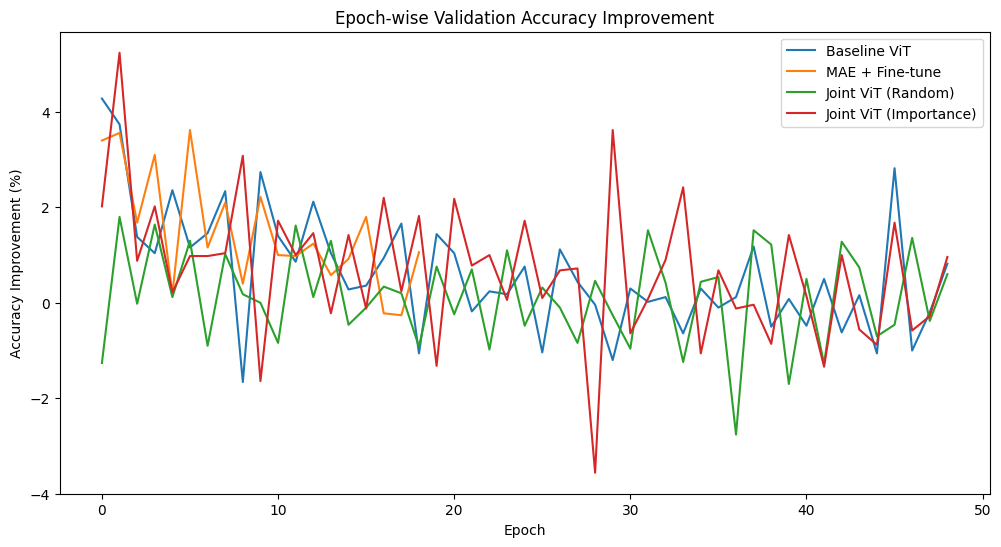

In [ ]:
plt.figure(figsize=(12, 6))
baseline_acc_diff = [baseline_accs[i] - baseline_accs[i-1] for i in range(1, len(baseline_accs))]
mae_acc_diff = [mae_accs[i] - mae_accs[i-1] for i in range(1, len(mae_accs))]
joint_rand_acc_diff = [joint_rand_accs[i] - joint_rand_accs[i-1] for i in range(1, len(joint_rand_accs))]
joint_imp_acc_diff = [joint_imp_accs[i] - joint_imp_accs[i-1] for i in range(1, len(joint_imp_accs))]
plt.plot(baseline_acc_diff, label='Baseline ViT')
plt.plot(mae_acc_diff, label='MAE + Fine-tune')
plt.plot(joint_rand_acc_diff, label='Joint ViT (Random)')
plt.plot(joint_imp_acc_diff, label='Joint ViT (Importance)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Improvement (%)')
plt.legend()
plt.title('Epoch-wise Validation Accuracy Improvement')
plt.savefig('acc_improvement_curves.png')

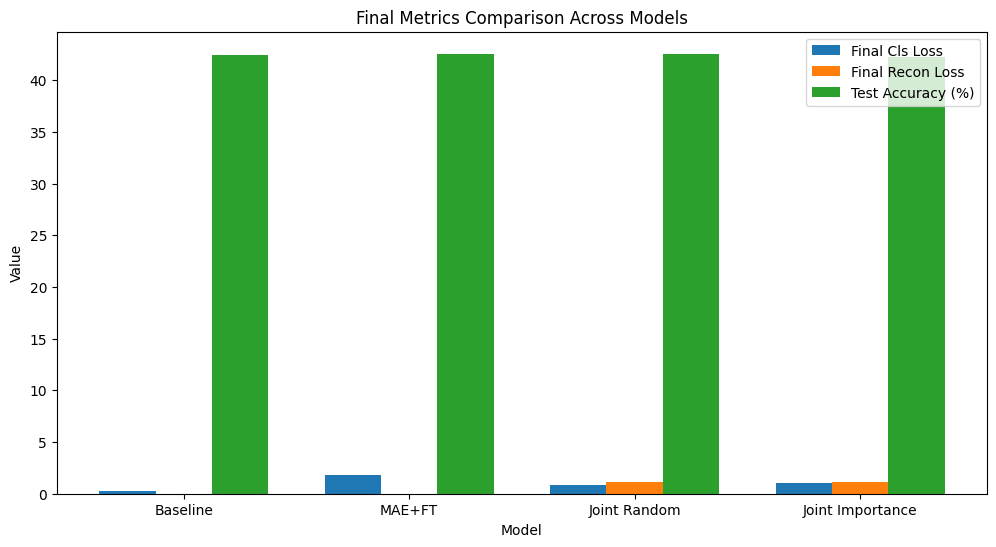

In [ ]:
plt.figure(figsize=(12, 6))
labels = ['Baseline', 'MAE+FT', 'Joint Random', 'Joint Importance']
final_cls_losses = [baseline_cls_losses[-1], mae_cls_losses[-1], joint_rand_cls_losses[-1], joint_imp_cls_losses[-1]]
final_recon_losses = [0, 0, joint_rand_recon_losses[-1], joint_imp_recon_losses[-1]]  # value of 0 for models w/o recon
final_test_accs = [baseline_test_acc, mae_test_acc, joint_rand_test_acc, joint_imp_test_acc]

x = np.arange(len(labels))
width = 0.25
plt.bar(x - width, final_cls_losses, width, label='Final Cls Loss')
plt.bar(x, final_recon_losses, width, label='Final Recon Loss')
plt.bar(x + width, final_test_accs, width, label='Test Accuracy (%)')
plt.xlabel('Model')
plt.ylabel('Value')
plt.xticks(x, labels)
plt.legend()
plt.title('Final Metrics Comparison Across Models')
plt.savefig('final_metrics_bar.png')

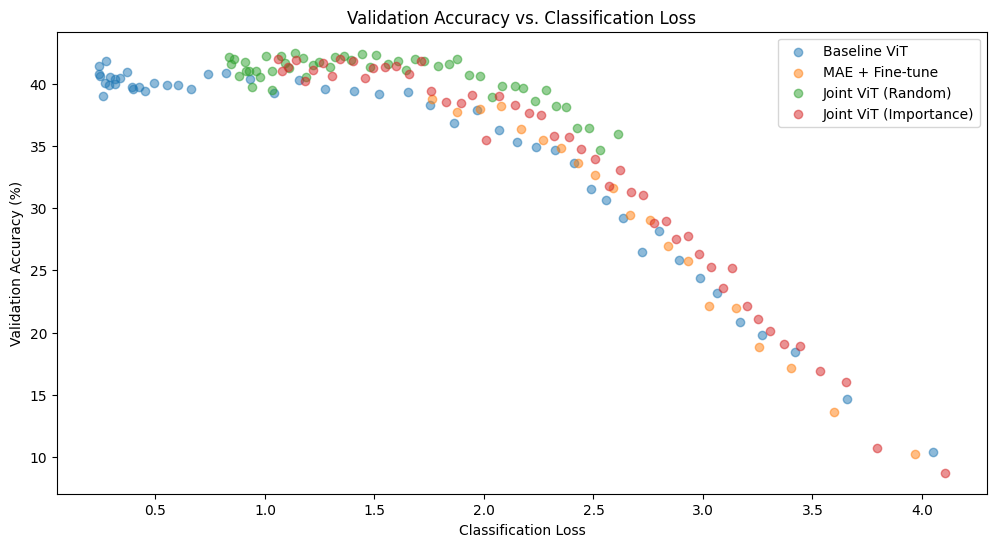

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(baseline_cls_losses, baseline_accs, label='Baseline ViT', alpha=0.5)
plt.scatter(mae_cls_losses, mae_accs, label='MAE + Fine-tune', alpha=0.5)
plt.scatter(joint_rand_cls_losses, joint_rand_accs, label='Joint ViT (Random)', alpha=0.5)
plt.scatter(joint_imp_cls_losses, joint_imp_accs, label='Joint ViT (Importance)', alpha=0.5)
plt.xlabel('Classification Loss')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy vs. Classification Loss')
plt.savefig('acc_vs_cls_loss.png')

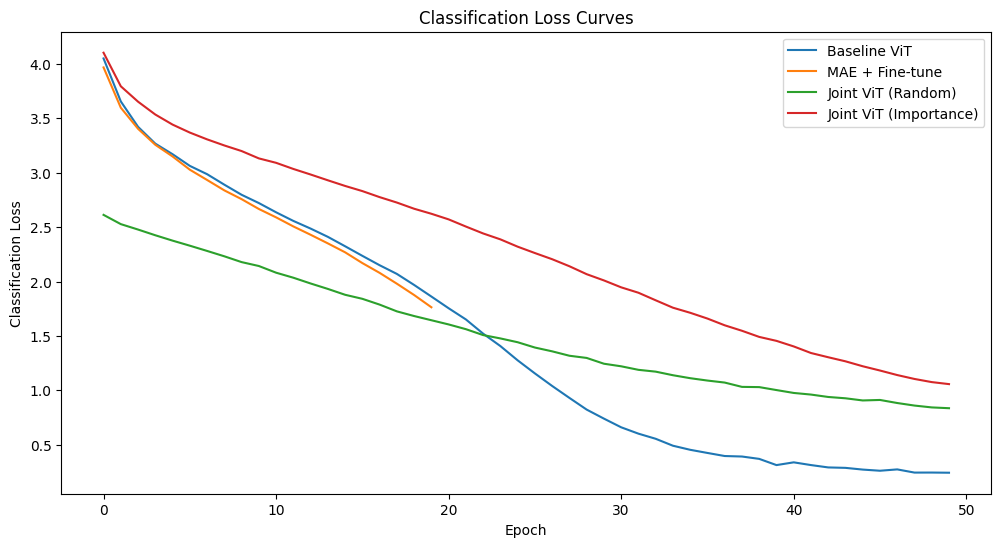

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(baseline_cls_losses, label='Baseline ViT')
plt.plot(mae_cls_losses, label='MAE + Fine-tune')
plt.plot(joint_rand_cls_losses, label='Joint ViT (Random)')
plt.plot(joint_imp_cls_losses, label='Joint ViT (Importance)')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.legend()
plt.title('Classification Loss Curves')
plt.savefig('cls_loss_curves.png')